In [2]:
#configure plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.figsize'] = (8,5)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['font.family'] = 'serif'

import GPy
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(1)

from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score

# Some hyperparameters

In [3]:
ndim = 2
total_n = 1000
start_n = 10
end_n = 600
test_size = 400

var = 100
lengthscale = 0.11

k = GPy.kern.RBF(ndim, variance=var, lengthscale=lengthscale)
lik = GPy.likelihoods.Bernoulli()

# Creating dataset

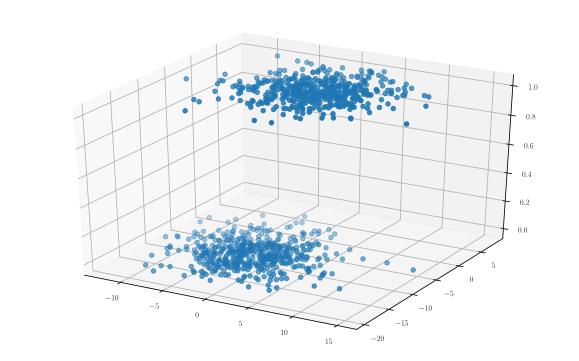

In [3]:
import GetData

Data = GetData.Generated2dimData(total_n, start_n, end_n, test_size)

U, X_train, y_U, y_train, X_test, y_test = Data.generate_data()

# An example Inference
To see whether gaussian process learns on the data

 /home/daria.kotova/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning:The following kwargs were not used by contour: 'linewidth', 'label'


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f7e962c3d50>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7f7e962c3c10>]}

 /home/daria.kotova/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


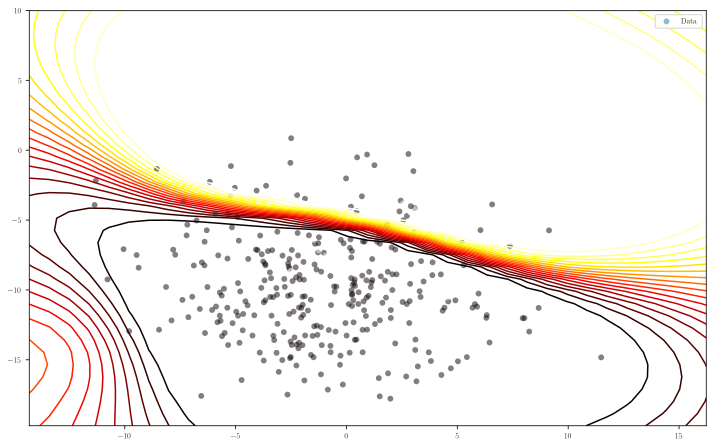

In [4]:
m = GPy.core.GP(X=U,
                Y=y_U.reshape(-1, 1), 
                kernel=k, 
                inference_method=GPy.inference.latent_function_inference.expectation_propagation.EP(),
                likelihood=lik)

m.optimize()
m.plot(plot_density = True)

# Preparation for actually experiments

In [5]:
#create structure of folders to store plots for different score_functions
!rm -r score_plots
!mkdir score_plots

!mkdir ./score_plots/rand
!mkdir ./score_plots/vari
!mkdir ./score_plots/sqsm
!mkdir ./score_plots/RKHS
!mkdir ./score_plots/Hvar
!mkdir ./score_plots/l2fm

In [6]:
!rm -r accuracies
!mkdir accuracies

In [7]:
!rm -r scores
!mkdir scores

!mkdir ./scores/rand
!mkdir ./scores/vari
!mkdir ./scores/sqsm
!mkdir ./scores/RKHS
!mkdir ./scores/Hvar
!mkdir ./scores/l2fm

# Active learning part

In [3]:
import ScoreFunctions
import Utils

# The main loop
Train 6 gps with different score function

In [6]:
acc_rand = []
acc_vari = []
acc_sqsm = []
acc_RKHS = []
acc_Hvar = []
acc_l2fm = []

models = []

# U = np.loadtxt("U.txt")
# y_U = np.loadtxt("y_U.txt")
# X_train = np.loadtxt("X_train.txt")
# y_train = np.loadtxt("y_train.txt")
# X_test = np.loadtxt("X_test.txt")
# y_test = np.loadtxt("y_test.txt")

# U_0 = np.loadtxt("U_0.txt")
# y_U_0 = np.loadtxt("y_U_0.txt")
# X_train_0 = X_train
# y_train_0 = y_train

# inv_K = np.loadtxt("inv_K.txt")

# X_train_0   = X_train
# y_train_0   = y_train
# U_0         = U
# y_U_0       = y_U
 

In [7]:
for score, acc in (zip((ScoreFunctions.calculate_scores_sqsm, ScoreFunctions.calculate_scores_vari),
                            (acc_sqsm, acc_vari))):
    X_train = X_train_0
    y_train = y_train_0
    U = U_0
    y_U = y_U_0
    
    k = GPy.kern.RBF(ndim, variance=var, lengthscale=lengthscale)
    m = GPy.core.GP(X=X_train,
                    Y=y_train.reshape(-1, 1), 
                    kernel=k, 
                    inference_method=GPy.inference.latent_function_inference.expectation_propagation.EP(),
                    likelihood=lik)
    
    K = Utils.get_K(m, X_train)
    inv_K = Utils.get_inv_K(m, X_train) 
    
    for i in tqdm(range(340, end_n)):
        #0. learn GP on the data
        m = GPy.core.GP(X=X_train,
                        Y=y_train.reshape(-1, 1), 
                        kernel=m.kern, 
                        inference_method=GPy.inference.latent_function_inference.expectation_propagation.EP(),
                        likelihood=lik)

        if i % 10 == 0:
            m.optimize(messages = False)
        
        #1. calculate score at each point of the rest dataset in U and y_u, get the ind of maximum
        scores = score(np.array(U), m, X_train, y_train, inv_K)
        ind = np.argmax(scores)
        
        Data.draw_score(m, U, "./score_plots/"+str(score)[27:31]+"/", i, X_train, score, y_train, inv_K)

        #2. append new point to the training dataset and remove it from U
        X_train = np.concatenate((X_train, U[ind].reshape(-1, ndim)), axis = 0)
        y_train = np.append(y_train, y_U[ind]).reshape(-1, 1)
        
        a = m.kern.K(U[ind].reshape(-1, ndim), X_train[:X_train.shape[0]-1]).T
        
        inv_K = Utils.update_inv_K(m, X_train, inv_K, U[ind], a)
        #placing this function call right here is important
        #since draw_score should see whole U included the point to be deleted
#         Data.draw_score(scores, U, "./score_plots/"+str(score)[27:31]+"/", i, X_train[-1], y_train[-1])

        U = np.delete(U, ind, axis = 0)
        y_U = np.delete(y_U, ind)

        #3. count accuracy
        cur_accuracy = accuracy_score(y_test, Utils.to_labels(m.predict(X_test.reshape(-1, ndim))[:][0]))
        acc.append(cur_accuracy)

        acc_file = open("./accuracies/acc_" + str(score)[27:31] + ".txt", 'a') 
        acc_file.write(str(cur_accuracy) + "\n")
        acc_file.close()
    
    #after the gp is learned save it to models
    models.append(m)

KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

In [ ]:
# np.savetxt("U.txt", U)
# np.savetxt("y_U.txt", y_U)
# np.savetxt("X_train.txt", X_train)
# np.savetxt("y_train.txt", y_train)
# np.savetxt("X_test.txt", X_test)
# np.savetxt("y_test.txt", y_test)

# np.savetxt("U_0.txt", U_0)
# np.savetxt("y_U_0.txt", y_U_0)
# np.savetxt("X_train_0.txt", X_train_0)
# np.savetxt("y_train_0.txt", y_train_0)

# print(i)

# m.save_model("m.json")

# np.savetxt("inv_K.txt", inv_K)

In [10]:
# for m in models:
#     m.plot(plot_density = True)
#     plt.plot(X_train, y_train, 'b.')

In [4]:
acc_rand = np.loadtxt("./accuracies/acc_rand.txt")
acc_vari = np.loadtxt("./accuracies/acc_vari.txt")
acc_sqsm = np.loadtxt("./accuracies/acc_sqsm.txt")
acc_RKHS = np.loadtxt("./accuracies/acc_RKHS.txt")
acc_Hvar = np.loadtxt("./accuracies/acc_Hvar.txt")
acc_l2fm = np.loadtxt("./accuracies/acc_l2fm.txt")

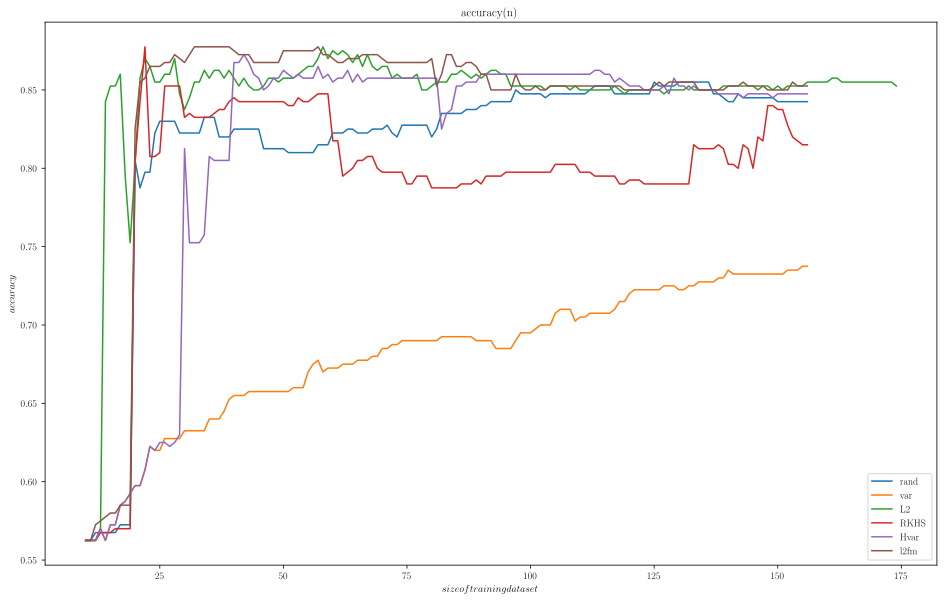

In [12]:
import matplotlib;matplotlib.rcParams['figure.figsize'] = (16,10)

partition = 4
partition1 = 2
plt.plot(range(start_n, start_n + len(acc_rand)/partition), acc_rand[:len(acc_rand)/partition], label='rand')
plt.plot(range(start_n, start_n + len(acc_vari)/partition), acc_vari[:len(acc_vari)/partition], label='var')
plt.plot(range(start_n, start_n + len(acc_sqsm)/partition1), acc_sqsm[:len(acc_sqsm)/partition1], label='L2')
plt.plot(range(start_n, start_n + len(acc_RKHS)/partition), acc_RKHS[:len(acc_RKHS)/partition], label='RKHS')
plt.plot(range(start_n, start_n + len(acc_Hvar)/partition), acc_Hvar[:len(acc_Hvar)/partition], label='Hvar')
plt.plot(range(start_n, start_n + len(acc_l2fm)/partition), acc_l2fm[:len(acc_l2fm)/partition], label='l2fm')

plt.title("accuracy(n)")
plt.ylabel('$accuracy$')
plt.xlabel('$size of training dataset$')
plt.legend()
plt.savefig('accuracy2dim' + str(partition) + '.png')